In [1]:
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from skimage.transform import resize
from skimage.io import imsave
from skimage.io import imread

In [2]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv3D, MaxPooling3D, Conv3DTranspose, AveragePooling3D, ZeroPadding3D
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras import backend as K
from keras.regularizers import l2
from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
def deform(array, factor, axis):
    stretched = np.repeat(array, np.ceil(factor), axis=axis)
    indices = np.linspace(0, stretched.shape[axis] - 1, int(array.shape[axis] * factor))
    indices = np.rint(indices).astype(int)
    return np.take(stretched, indices, axis=axis)

In [4]:
data_path = './'
project_name = '3D-Unet'
img_depth = 32
img_rows = 64
img_cols = 64
smooth = 1.

In [5]:
K.set_image_data_format('channels_last')

In [6]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_unet():
    inputs = Input((img_depth, img_rows, img_cols, 1))
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5), conv4], axis=4)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6), conv3], axis=4)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7), conv2], axis=4)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8), conv1], axis=4)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)


    model = Model(inputs=[inputs], outputs=[conv10])

    model.summary()
    #plot_model(model, to_file='model.png')

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [7]:
def train():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    
    a = np.load('a.npz')['arr_0']
    b = np.load('b.npz')['arr_0']
    
    a = np.transpose(a)
    b = np.transpose(b)
    
    a = deform(a, img_depth/a.shape[0], axis=0)
    a = deform(a, img_rows/a.shape[1], axis=1)
    a = deform(a, img_cols/a.shape[2], axis=2)
    
    b = deform(b, img_depth/b.shape[0], axis=0)
    b = deform(b, img_rows/b.shape[1], axis=1)
    b = deform(b, img_cols/b.shape[2], axis=2)

    A = np.array([a,a,a,a,a,a,a,a,a,a])
    B = np.array([b,b,b,b,b,b,b,b,b,b])
    
    imgs_train = np.expand_dims(A, axis=4)
    imgs_mask_train = np.expand_dims(B, axis=4)
    
    imgs_train = imgs_train.astype('float32')
    imgs_mask_train = imgs_mask_train.astype('float32')
    
    print(imgs_mask_train.shape)
    print(imgs_train.shape)

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    weight_dir = 'weights'
    if not os.path.exists(weight_dir):
        os.mkdir(weight_dir)
    model_checkpoint = ModelCheckpoint(os.path.join(weight_dir, project_name + '.h5'), monitor='val_loss', save_best_only=True)

    log_dir = 'logs'
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    csv_logger = CSVLogger(os.path.join(log_dir,  project_name + '.txt'), separator=',', append=False)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)

    model.fit(imgs_train, imgs_mask_train, batch_size=1, epochs=200, verbose=1, shuffle=True, validation_split=0.20, callbacks=[model_checkpoint, csv_logger])

    print('-'*30)
    print('Training finished')
    print('-'*30)
    
    A = np.array([a])
    imgs_train = np.expand_dims(A, axis=4)
    imgs_test = imgs_train.astype('float32')
    
    imgs_mask_test = model.predict(imgs_test, batch_size=1, verbose=1)

    npy_mask_dir = 'test_mask_npy'
    if not os.path.exists(npy_mask_dir):
        os.mkdir(npy_mask_dir)

    np.save(os.path.join(npy_mask_dir, project_name + '_mask.npy'), imgs_mask_test)

In [8]:
train()

------------------------------
Loading and preprocessing train data...
------------------------------
(10, 32, 64, 64, 1)
(10, 32, 64, 64, 1)
------------------------------
Creating and compiling model...
------------------------------
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 64, 64, 1 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 32, 64, 64, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 32, 64, 64, 3 27680       conv3d_1[0][0]                   
______________________________________________________

8/8 [==============================] - 2s 310ms/step - loss: -0.0179 - dice_coef: 0.0179 - val_loss: -0.0180 - val_dice_coef: 0.0180
Epoch 6/200
8/8 [==============================] - 2s 311ms/step - loss: -0.0180 - dice_coef: 0.0180 - val_loss: -0.0181 - val_dice_coef: 0.0181
Epoch 7/200
8/8 [==============================] - 2s 309ms/step - loss: -0.0181 - dice_coef: 0.0181 - val_loss: -0.0181 - val_dice_coef: 0.0181
Epoch 8/200
8/8 [==============================] - 2s 309ms/step - loss: -0.0182 - dice_coef: 0.0182 - val_loss: -0.0183 - val_dice_coef: 0.0183
Epoch 9/200
8/8 [==============================] - 2s 309ms/step - loss: -0.0183 - dice_coef: 0.0183 - val_loss: -0.0184 - val_dice_coef: 0.0184
Epoch 10/200
8/8 [==============================] - 2s 310ms/step - loss: -0.0184 - dice_coef: 0.0184 - val_loss: -0.0185 - val_dice_coef: 0.0185
Epoch 11/200
8/8 [==============================] - 2s 309ms/step - loss: -0.0186 - dice_coef: 0.0186 - val_loss: -0.0187 - val_dice_coef: 0.

8/8 [==============================] - 2s 310ms/step - loss: -0.6902 - dice_coef: 0.6902 - val_loss: -0.6966 - val_dice_coef: 0.6966
Epoch 62/200
8/8 [==============================] - 2s 310ms/step - loss: -0.7023 - dice_coef: 0.7023 - val_loss: -0.7090 - val_dice_coef: 0.7090
Epoch 63/200
8/8 [==============================] - 2s 310ms/step - loss: -0.6958 - dice_coef: 0.6958 - val_loss: -0.6750 - val_dice_coef: 0.6750
Epoch 64/200
8/8 [==============================] - 2s 310ms/step - loss: -0.6927 - dice_coef: 0.6927 - val_loss: -0.7108 - val_dice_coef: 0.7108
Epoch 65/200
8/8 [==============================] - 3s 313ms/step - loss: -0.7099 - dice_coef: 0.7099 - val_loss: -0.6996 - val_dice_coef: 0.6996
Epoch 66/200
8/8 [==============================] - 2s 309ms/step - loss: -0.6983 - dice_coef: 0.6983 - val_loss: -0.7076 - val_dice_coef: 0.7076
Epoch 67/200
8/8 [==============================] - 2s 310ms/step - loss: -0.6932 - dice_coef: 0.6932 - val_loss: -0.6641 - val_dice_coef

8/8 [==============================] - 2s 310ms/step - loss: -0.7668 - dice_coef: 0.7668 - val_loss: -0.7936 - val_dice_coef: 0.7936
Epoch 118/200
8/8 [==============================] - 2s 310ms/step - loss: -0.7783 - dice_coef: 0.7783 - val_loss: -0.7824 - val_dice_coef: 0.7824
Epoch 119/200
8/8 [==============================] - 2s 311ms/step - loss: -0.7851 - dice_coef: 0.7851 - val_loss: -0.7929 - val_dice_coef: 0.7929
Epoch 120/200
8/8 [==============================] - 2s 310ms/step - loss: -0.7975 - dice_coef: 0.7975 - val_loss: -0.8017 - val_dice_coef: 0.8017
Epoch 121/200
8/8 [==============================] - 2s 311ms/step - loss: -0.8034 - dice_coef: 0.8034 - val_loss: -0.8047 - val_dice_coef: 0.8047
Epoch 122/200
8/8 [==============================] - 2s 310ms/step - loss: -0.7962 - dice_coef: 0.7962 - val_loss: -0.7511 - val_dice_coef: 0.7511
Epoch 123/200
8/8 [==============================] - 2s 310ms/step - loss: -0.7888 - dice_coef: 0.7888 - val_loss: -0.7957 - val_dic

Epoch 173/200
8/8 [==============================] - 2s 308ms/step - loss: -0.8278 - dice_coef: 0.8278 - val_loss: -0.8278 - val_dice_coef: 0.8278
Epoch 174/200
8/8 [==============================] - 2s 310ms/step - loss: -0.8278 - dice_coef: 0.8278 - val_loss: -0.8278 - val_dice_coef: 0.8278
Epoch 175/200
8/8 [==============================] - 2s 309ms/step - loss: -0.8278 - dice_coef: 0.8278 - val_loss: -0.8279 - val_dice_coef: 0.8279
Epoch 176/200
8/8 [==============================] - 2s 309ms/step - loss: -0.8279 - dice_coef: 0.8279 - val_loss: -0.8279 - val_dice_coef: 0.8279
Epoch 177/200
8/8 [==============================] - 2s 309ms/step - loss: -0.8279 - dice_coef: 0.8279 - val_loss: -0.8279 - val_dice_coef: 0.8279
Epoch 178/200
8/8 [==============================] - 2s 312ms/step - loss: -0.8279 - dice_coef: 0.8279 - val_loss: -0.8279 - val_dice_coef: 0.8279
Epoch 179/200
8/8 [==============================] - 2s 310ms/step - loss: -0.8279 - dice_coef: 0.8279 - val_loss: -0.

In [9]:
a = np.load('a.npz')['arr_0']
a = np.transpose(a)
a = np.resize(a, (32,64,64))
A = np.array([a])
imgs_train = np.expand_dims(A, axis=4)
imgs_test = imgs_train.astype('float32')

imgs_test.shape

(1, 32, 64, 64, 1)

In [10]:
a = np.load('a.npz')['arr_0']
    
a = np.transpose(a)

a = deform(a, img_depth/a.shape[0], axis=0)
a = deform(a, img_rows/a.shape[1], axis=1)
a = deform(a, img_cols/a.shape[2], axis=2)

In [11]:
b = np.load('b.npz')['arr_0']

b = np.transpose(b)

b = deform(b, img_depth/b.shape[0], axis=0)
b = deform(b, img_rows/b.shape[1], axis=1)
b = deform(b, img_cols/b.shape[2], axis=2)

In [12]:
print(a.shape, b.shape)

(32, 64, 64) (32, 64, 64)


In [13]:
os.chdir('test_mask_npy')

In [14]:
c = np.load('3D-Unet_mask.npy')
c.shape

(1, 32, 64, 64, 1)

In [15]:
c = c[0,:,:,:,0]
c.shape

(32, 64, 64)

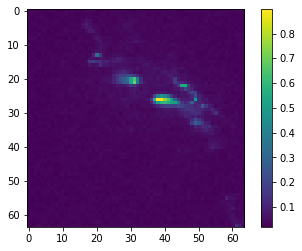

In [16]:
# input image
plt.imshow(a[15,:,:])
plt.colorbar()

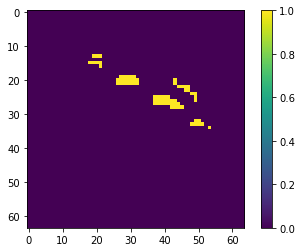

In [17]:
# ground truth
plt.imshow(b[15,:,:])
plt.colorbar()

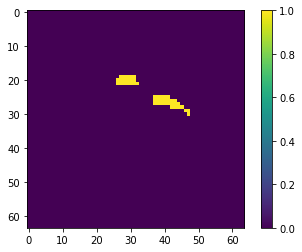

In [18]:
# output mask
plt.imshow(c[15,:,:])
plt.colorbar()

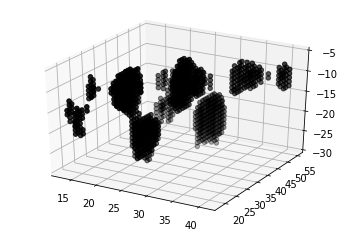

In [19]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

z,x,y = b.nonzero()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'black')

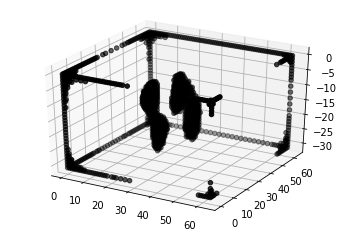

In [20]:
z,x,y = c.nonzero()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'black')